# Import learning data

In [37]:
import pandas as pd

data_path = "../learning_data/data/win_rate/preflop/100-data-100-simulation-2-players-win-rate-data.csv"
df = pd.read_csv(data_path)

# About learning data

In [38]:
df.shape

(100, 5)

In [39]:
df.head()

,hole1,hole2,win_rate,hole1_id,hole2_id
0,D4,C6,0.52,17,6
1,S5,D7,0.57,44,20
2,D4,HA,0.60,17,27
3,DA,DK,0.65,14,26
4,D2,DA,0.54,15,14


In [40]:
df.describe()

,win_rate,hole1_id,hole2_id
count,100.000000,100.000000,100.000000
mean,0.591900,25.810000,27.210000
std,0.082801,16.841324,14.161618
min,0.380000,1.000000,2.000000
25%,0.530000,11.000000,14.000000
50%,0.595000,24.500000,25.500000
75%,0.650000,42.250000,40.250000
max,0.810000,52.000000,51.000000


# Data Processing

## card id -> 1-hot vector

In [78]:
import numpy as np

gen_one_hot = lambda h1, h2: [1 if i in [h1, h2] else 0 for i in range(1,53)]
df["onehot"] = df.apply(lambda row: gen_one_hot(row['hole1_id'], row['hole2_id']), axis=1)

## Separate data for training and validation

In [52]:
validation_rate = 0.1
boundary_idx = int(df.shape[0]*(1-validation_rate))
train_df = df[:boundary_idx]
validation_df = df[boundary_idx:]

## Format data (pandas.df -> numpy.ndarray)

In [108]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
val_x, val_y = [to_ndarray(array) for array in [validation_df["onehot"].values, validation_df["win_rate"].values]]
print "shape of training x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of validation x: %s, y: %s" % (val_x.shape, val_y.shape)

shape of training x: (90, 52), y: (90,)
shape of validation x: (10, 52), y: (10,)


# Create model

In [133]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=52))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

# Train model

In [134]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=100, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

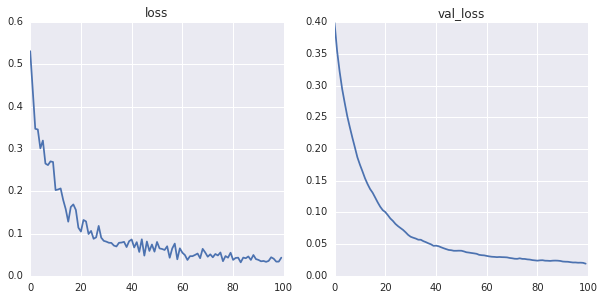

In [135]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [136]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, val_x, val_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on validation data = {score}'.format(score=mean_squared_error(model.predict(val_x), val_y))

In [137]:
print_model_performance(model, train_x, train_y, val_x, val_y)

MSE on training data = 0.00476947814604
MSE on validation data = 0.00924746102972


## See model prediction on sample data

In [153]:
from pypokerengine.engine.card import Card

test_case = [
    (1, Card.SPADE, 1, Card.CLUB, 0.871), 
    (3, Card.HEART, 2, Card.SPADE, 0.477),
    (10, Card.CLUB, 13, Card.HEART, 0.676)
]
gen_one_hot = lambda h1, h2: [1 if i in [h1, h2] else 0 for i in range(1,53)]

df = pd.DataFrame()
for rank1, suit1, rank2, suit2, expected in test_case:
    hole1 = Card(rank=rank1, suit=suit1)
    hole2 = Card(rank=rank2, suit=suit2)
    hole = [hole1, hole2]
    x = gen_one_hot(*[card.to_id() for card in hole])
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole)+ [y , expected])

HOLE = [SA, CA] => win_rate = { prediction=0.746346, expected=0.871000 }
HOLE = [H3, S2] => win_rate = { prediction=0.459061, expected=0.477000 }
HOLE = [CT, HK] => win_rate = { prediction=0.194115, expected=0.676000 }
